In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score


In [5]:
# load the cleaned dataset
data_path = "cleaned_diabetic_data.csv"
df = pd.read_csv(data_path)
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,readmitted,readmitted_binary,admission_type,discharge_disposition,admission_source,diag_1_group,diag_2_group,diag_3_group,med_count,age_numeric
0,12522,48330783,Caucasian,Female,[80-90),2,1,4,13,68,...,NO,0,Urgent,Discharged to home,Transfer from hospital,Circulatory,Circulatory,Infectious and parasitic diseases,2,85
1,15738,63555939,Caucasian,Female,[90-100),3,3,4,12,33,...,NO,0,Elective,To SNF,Transfer from hospital,Circulatory,Neoplasms,Respiratory,2,95
2,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,NO,0,Emergency,Discharged to home,Emergency Room,Neoplasms,Neoplasms,Diabetes,2,45
3,28236,89869032,AfricanAmerican,Female,[40-50),1,1,7,9,47,...,>30,0,Emergency,Discharged to home,Emergency Room,Diabetes,Circulatory,Injury,1,45
4,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,31,...,>30,0,Urgent,Discharged to home,Clinic Referral,Circulatory,Circulatory,Diabetes,1,55


In [6]:
med_cols = [ 'metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide','citoglipton','insulin','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone']

def create_enhanced_features(df):
    """Creating new features to enhance model predictive power"""
    print("="*50)
    print("FEATURE ENGINEERING")
    print("="*50)
    
    df_enhanced = df.copy()

    # Count how many meds are 'Up' or 'Down' (changed dose)
    df_enhanced['meds_changed'] = df[med_cols].apply(lambda row: row.isin(['Up', 'Down']).sum(), axis=1)
    
        
    print(f"Enhanced features created. Dataset shape: {df_enhanced.shape}")
    return df_enhanced

# create a fun that create X and Y along with some feature engineer
def create_X_Y_datasets(df):
    df = create_enhanced_features(df)

    X = df.drop(columns=med_cols + ['readmitted_binary', 'diag_1', 'diag_2', 'diag_3', 'age', 'encounter_id', 'patient_nbr', 'readmitted', 'num_lab_procedures', 'discharge_disposition', 'admission_source', 'admission_type', 'race'])
    y = df['readmitted_binary']

    X_encoded = pd.get_dummies(X, drop_first=True)

    # Split the dataset into training and testing and validation sets
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)
    # print out the shape of the datasets
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


    return X_train, X_test, y_train, y_test


# Create the datasets
X_train, X_test, y_train, y_test = create_X_Y_datasets(df)



FEATURE ENGINEERING
Enhanced features created. Dataset shape: (69988, 57)
X_train shape: (48991, 80), y_train shape: (48991,)
X_test shape: (20997, 80), y_test shape: (20997,)


In [7]:


def train_xgboost_model(X_train, y_train, random_seed=42, scale_pos_weight=None):

    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

    xgb_model = xgb.XGBClassifier(
        random_state=random_seed,
        eval_metric="auc",
        enable_categorical=True,
        n_estimators=100,
        scale_pos_weight=scale_pos_weight
    )

    # Fit the model
    xgb_model.fit(X_train, y_train)
    return xgb_model

# Train the model
xgb_model = train_xgboost_model(X_train, y_train)
# Evaluate the model on the validation set
from sklearn.metrics import accuracy_score, classification_report

y_proba = xgb_model.predict_proba(X_test)[:, 1]
for threshold in [0.5, 0.4, 0.3, 0.2]:
    y_pred = (y_proba >= threshold).astype(int)
    print(f"\nThreshold: {threshold}")
    print(classification_report(y_test, y_pred))


Threshold: 0.5
              precision    recall  f1-score   support

           0       0.93      0.75      0.83     19086
           1       0.14      0.41      0.21      1911

    accuracy                           0.72     20997
   macro avg       0.53      0.58      0.52     20997
weighted avg       0.85      0.72      0.77     20997


Threshold: 0.4
              precision    recall  f1-score   support

           0       0.94      0.54      0.68     19086
           1       0.12      0.63      0.20      1911

    accuracy                           0.55     20997
   macro avg       0.53      0.58      0.44     20997
weighted avg       0.86      0.55      0.64     20997


Threshold: 0.3
              precision    recall  f1-score   support

           0       0.94      0.33      0.49     19086
           1       0.11      0.79      0.19      1911

    accuracy                           0.37     20997
   macro avg       0.52      0.56      0.34     20997
weighted avg       0.86   

In [8]:
from sklearn.metrics import roc_auc_score

# y_test: true labels (0 or 1)
# y_proba: predicted probabilities for class 1
auc_score = roc_auc_score(y_test, y_proba)

print(f"AUC Score: {auc_score:.4f}")

AUC Score: 0.6181


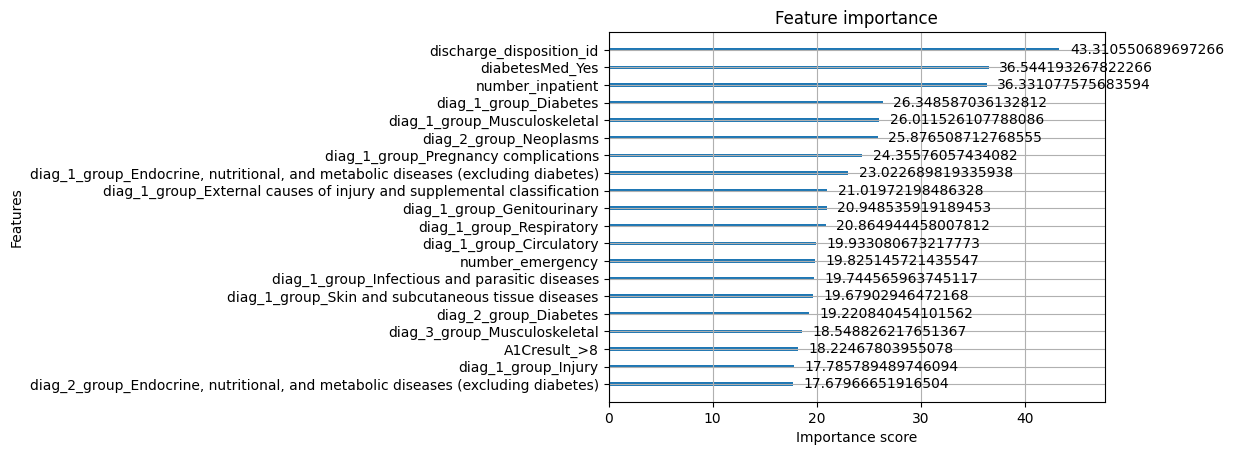

In [9]:
xgb.plot_importance(xgb_model, max_num_features=20, importance_type='gain')
plt.show()

In [10]:
import pandas as pd

# Assuming you already trained the model and used get_dummies for X
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
})

# Sort by importance descending
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Display the table
print(feature_importance.head(20))  # Top 20 important features

                                              Feature  Importance
1                            discharge_disposition_id    0.032028
22                                    diabetesMed_Yes    0.027024
8                                    number_inpatient    0.026867
25                              diag_1_group_Diabetes    0.019485
33                       diag_1_group_Musculoskeletal    0.019235
53                             diag_2_group_Neoplasms    0.019136
38               diag_1_group_Pregnancy complications    0.018011
27  diag_1_group_Endocrine, nutritional, and metab...    0.017025
28  diag_1_group_External causes of injury and sup...    0.015544
29                         diag_1_group_Genitourinary    0.015491
39                           diag_1_group_Respiratory    0.015430
23                           diag_1_group_Circulatory    0.014740
7                                    number_emergency    0.014661
30     diag_1_group_Infectious and parasitic diseases    0.014601
41  diag_1